In [1]:
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import pandas as pd
import numpy as np
import itertools
import random
import math
import sys

In [2]:
df_tr = pd.read_csv("ML_FP_train_updated.csv")
df_t = pd.read_csv("ML_FP_test_updated_v1_com.csv")

# df_tr.shape (17170, 29)
# random_rows = df_tr.sample(n=10)
# print(random_rows)
print(df_tr.columns)

dep_var = 'Danceability'
indep_var = [col for col in df_tr.columns if col != dep_var]
X_tr = df_tr[indep_var]
X_t = df_t[indep_var]
y_tr = df_tr[dep_var]

# Standardize the input features
scaler = StandardScaler()
X_tr_scaled = scaler.fit_transform(X_tr)
X_t_scaled = scaler.transform(X_t)
# Fill NaN values with 0
X_tr_scaled = np.nan_to_num(X_tr_scaled, nan=0)
X_t_scaled = np.nan_to_num(X_t_scaled, nan=0)
X_tr_scaled = pd.DataFrame(X_tr_scaled, columns=indep_var)
X_t_scaled = pd.DataFrame(X_t_scaled, columns=indep_var)

Index(['Danceability', 'Energy', 'Key', 'Loudness', 'Speechiness',
       'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo',
       'Duration_ms', 'Views', 'Likes', 'Stream', 'Composer', 'Artist',
       'Licensed', 'official_video', 'Album_type'],
      dtype='object')


#### OLS_all

In [3]:
# Fit the robust OLS model
robust_model = sm.RLM(y_tr, X_tr_scaled, M=sm.robust.norms.HuberT())
robust_results = robust_model.fit()

ols_scaled_t = robust_results.predict(X_t_scaled)
ols_scaled_t = ols_scaled_t.round().astype(int)
ols_scaled_t = ols_scaled_t.clip(0, 9)

ols_scaled_df = pd.DataFrame({'id': df_t['id'], 'Danceability': ols_scaled_t})
ols_scaled_df.to_csv('ols_scaled_robust_submission.csv', index=False)

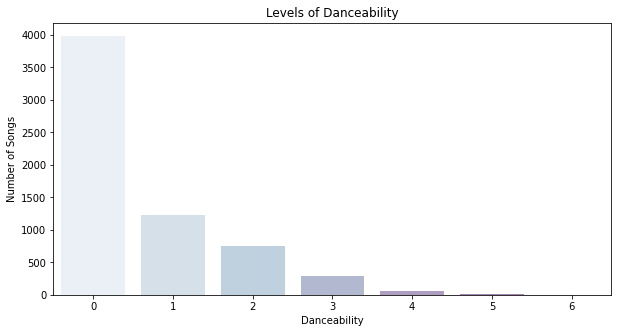

In [4]:
ols_scaled_df["Danceability"] = ols_scaled_df["Danceability"].astype("category")
# Target Variable Countplot
plt.figure(figsize = (10, 5))
sns.countplot(data=ols_scaled_df, x="Danceability", alpha = .70, palette = "BuPu")
plt.title("Levels of Danceability")
plt.ylabel("Number of Songs")
plt.show()

###### Score: 2.10547 (fillna = median)

#### MLogit

In [5]:
# Convert 'Danceability' to categorical classes
y_tr_categorical = y_tr.round().astype(int)
y_tr_categorical = y_tr_categorical.clip(0, 9)

# with statsmodels using multinomial logistic regression
X_tr_scaled = sm.add_constant(X_tr_scaled) # adding a constant
X_t_scaled = sm.add_constant(X_t_scaled)
mlogit_model = sm.MNLogit(y_tr_categorical, X_tr_scaled).fit()

mlogit_predictions_t = mlogit_model.predict(X_t_scaled)
# Convert the predicted probabilities to class labels
mlogit_predictions_t = mlogit_predictions_t.idxmax(axis=1)

mlogit_predictions_df = pd.DataFrame({'id': df_t['id'], 'Danceability': mlogit_predictions_t})
mlogit_predictions_df.to_csv('mlogit_all_submission.csv', index=False)

print_mlogit_model = mlogit_model.summary()
print(print_mlogit_model)

Optimization terminated successfully.
         Current function value: 2.011186
         Iterations 9
                          MNLogit Regression Results                          
Dep. Variable:           Danceability   No. Observations:                17170
Model:                        MNLogit   Df Residuals:                    16999
Method:                           MLE   Df Model:                          162
Date:                Mon, 12 Jun 2023   Pseudo R-squ.:                  0.1261
Time:                        16:16:49   Log-Likelihood:                -34532.
converged:                       True   LL-Null:                       -39513.
Covariance Type:            nonrobust   LLR p-value:                     0.000
  Danceability=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.9733      0.063     15.352      0.000       0.849       1.098
Energy     

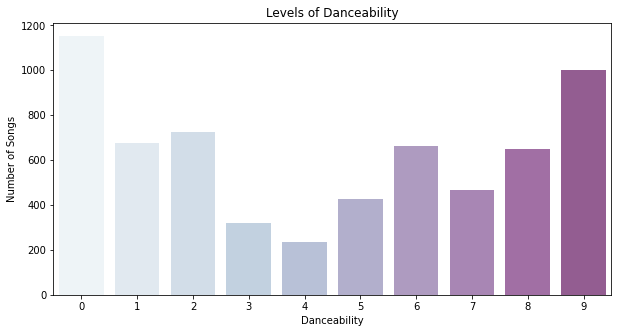

In [6]:
# Target Variable Countplot
plt.figure(figsize = (10, 5))
sns.countplot(data=mlogit_predictions_df, x="Danceability", alpha = .70, palette = "BuPu")
plt.title("Levels of Danceability")
plt.ylabel("Number of Songs")
plt.show()

mlogit_predictions_df["Danceability"] = mlogit_predictions_df["Danceability"].astype("int")

#### OLS_Ridge

Best alpha: 10.0


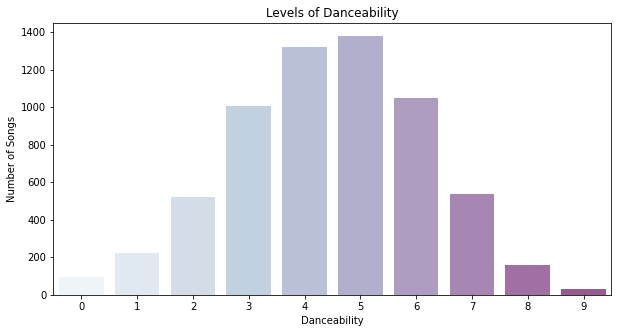

In [7]:
from sklearn.linear_model import Ridge, RidgeCV

# Perform Ridge regression
alphas = [0.01, 0.1, 0.5, 1.0, 5.0, 10.0]  # List of alpha values to try
ridge_cv = RidgeCV(alphas=alphas, cv=6)  # RidgeCV performs cross-validation
ridge_cv.fit(X_tr_scaled, y_tr)
best_alpha = ridge_cv.alpha_
print("Best alpha:", best_alpha)  # best_alpha=10

alpha = 10  # Regularization parameter
ridge_model = Ridge(alpha=alpha)
ridge_model.fit(X_tr_scaled, y_tr)

# Make predictions on the test data
ridge_predictions_t = ridge_model.predict(X_t_scaled)
ridge_predictions_t = ridge_predictions_t.round().astype(int)
ridge_predictions_t = ridge_predictions_t.clip(0, 9)

ridge_predictions_df = pd.DataFrame({'id': df_t['id'], 'Danceability': ridge_predictions_t})
ridge_predictions_df.to_csv('ridge_submission.csv', index=False)

# Target Variable Countplot
plt.figure(figsize = (10, 5))
sns.countplot(data=ridge_predictions_df, x="Danceability", alpha = .70, palette = "BuPu")
plt.title("Levels of Danceability")
plt.ylabel("Number of Songs")
plt.show()

#### LASSO

Best alpha: 0.01


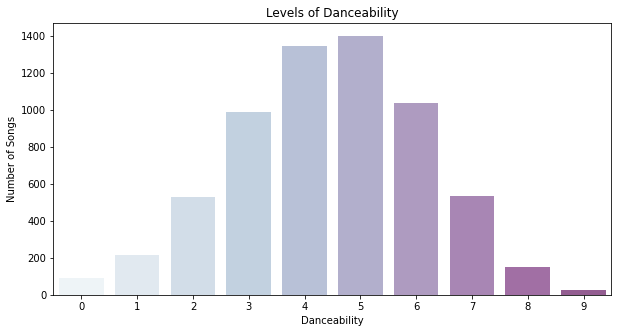

In [8]:
from sklearn.linear_model import Lasso, LassoCV

# Perform Lasso regression
alphas = [0.01, 0.1, 0.5, 1.0, 5.0, 10.0]  # List of alpha values to try
lasso_cv = LassoCV(alphas=alphas, cv=6)  # LassoCV performs cross-validation
lasso_cv.fit(X_tr_scaled, y_tr)
best_alpha = lasso_cv.alpha_
print("Best alpha:", best_alpha)  # best_alpha=10

alpha = 0.01  # Regularization parameter
lasso_model = Lasso(alpha=alpha)
lasso_model.fit(X_tr_scaled, y_tr)

# Make predictions on the test data
lasso_predictions_t = lasso_model.predict(X_t_scaled)
lasso_predictions_t = lasso_predictions_t.round().astype(int)
lasso_predictions_t = lasso_predictions_t.clip(0, 9)

lasso_predictions_df = pd.DataFrame({'id': df_t['id'], 'Danceability': lasso_predictions_t})
lasso_predictions_df.to_csv('lasso_submission.csv', index=False)

# Target Variable Countplot
plt.figure(figsize=(10, 5))
sns.countplot(data=lasso_predictions_df, x="Danceability", alpha=0.7, palette="BuPu")
plt.title("Levels of Danceability")
plt.ylabel("Number of Songs")
plt.show()


#### Neural Network Classifier

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

dep_var = 'Danceability'
indep_var = [col for col in df_tr.columns if col != dep_var]
X_tr = df_tr[indep_var]
X_t = df_t[indep_var]
y_tr = df_tr[dep_var]

# Prepare the data
X_tr = df_tr[indep_var]
X_t = df_t[indep_var]
y_tr = df_tr[dep_var]

# Standardize the input features
scaler = StandardScaler()
X_tr_scaled = scaler.fit_transform(X_tr)
X_t_scaled = scaler.transform(X_t)

# Check the distribution of the target variable
print(y_tr.value_counts())

# Convert target variable to integer labels (if needed)
# y_tr = label_encoding_function(y_tr)

# Create the neural network model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(len(indep_var),)))
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_tr_scaled, y_tr, epochs=50, batch_size=32)

# Use the trained model to predict y_t
predictions = model.predict(X_t_scaled)
predicted_classes = predictions.argmax(axis=1)

# Create a dataframe with the predictions
predictions_df = pd.DataFrame({'id': df_t['id'], 'Danceability': predicted_classes})
print(predictions_df)

# Save the predictions to a CSV file
predictions_df.to_csv('neural_network_submission.csv', index=False)


8.0    1860
6.0    1856
7.0    1826
5.0    1702
3.0    1675
2.0    1664
0.0    1655
9.0    1654
4.0    1639
1.0    1639
Name: Danceability, dtype: int64
Epoch 1/50
537/537 [==============================] - 2s 2ms/step - loss: nan - accuracy: 0.0962
Epoch 2/50
537/537 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.0964A: 0s - loss: nan - accuracy: 
Epoch 3/50
537/537 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.0964
Epoch 4/50
537/537 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.0964
Epoch 5/50
537/537 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.0964A: 0s - loss: nan
Epoch 6/50
537/537 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.0964
Epoch 7/50
537/537 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.0964
Epoch 8/50
537/537 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.0964
Epoch 9/50
537/537 [====

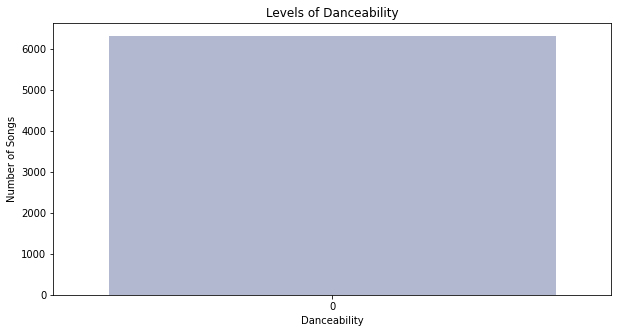

In [10]:
predictions_df["Danceability"] = predictions_df["Danceability"].astype("category")
# Target Variable Countplot
plt.figure(figsize = (10, 5))
sns.countplot(data=predictions_df, x="Danceability", alpha = .70, palette = "BuPu")
plt.title("Levels of Danceability")
plt.ylabel("Number of Songs")
plt.show()